In [1]:
import re
import os
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image, create_circular_mask, get_height_map, get_circular_std, get_circular_sum, get_circular_kurtosis, get_circular_ratio, get_bright_sum, get_ellipse_coefficient, get_histogram_matrix
from utils.dataset import get_train_data, get_test_data, get_private_test_data

plt.rcParams["figure.figsize"] = (10, 10)

## Загружаем данные для обучения

In [2]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(80, 80), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)

100%|██████████| 6758/6758 [00:00<00:00, 24135.72it/s]


## Отфильтровываем смещенные пятна и генерируем фичи

In [3]:
df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

df['circular_std'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_std)(img) for img in tqdm(df['img_80']))
df['circular_sum'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_sum)(img) for img in tqdm(df['img_80']))
df['circular_kurtosis'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_kurtosis)(img) for img in tqdm(df['img_80']))
df['ellipse_coefficient'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_ellipse_coefficient)(img) for img in tqdm(df['img_80']))

100%|██████████| 8909/8909 [00:01<00:00, 4713.75it/s]


In [4]:
df.head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Формируем усредненную матрицу гистограмм для каждой частицы и ищем расхождение между ней и гистограммами частиц

In [6]:
df['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df['img_80']))

mean_hist_matrix = []
for e in [3, 10]:
    mean_hist_matrix.append(np.mean(df[(df.t==0)&(df.e==e)]['hist_matrix']))
    
for e in [1, 6, 20]:
    mean_hist_matrix.append(np.mean(df[(df.t==1)&(df.e==e)]['hist_matrix']))
    
mean_hist_matrix = np.array(mean_hist_matrix)

for i in range(len(mean_hist_matrix)):
    df['error_'+str(i)] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix[i], hist_matrix) for hist_matrix in df['hist_matrix'])

100%|██████████| 8909/8909 [00:01<00:00, 4674.19it/s]


### Scatter matrix

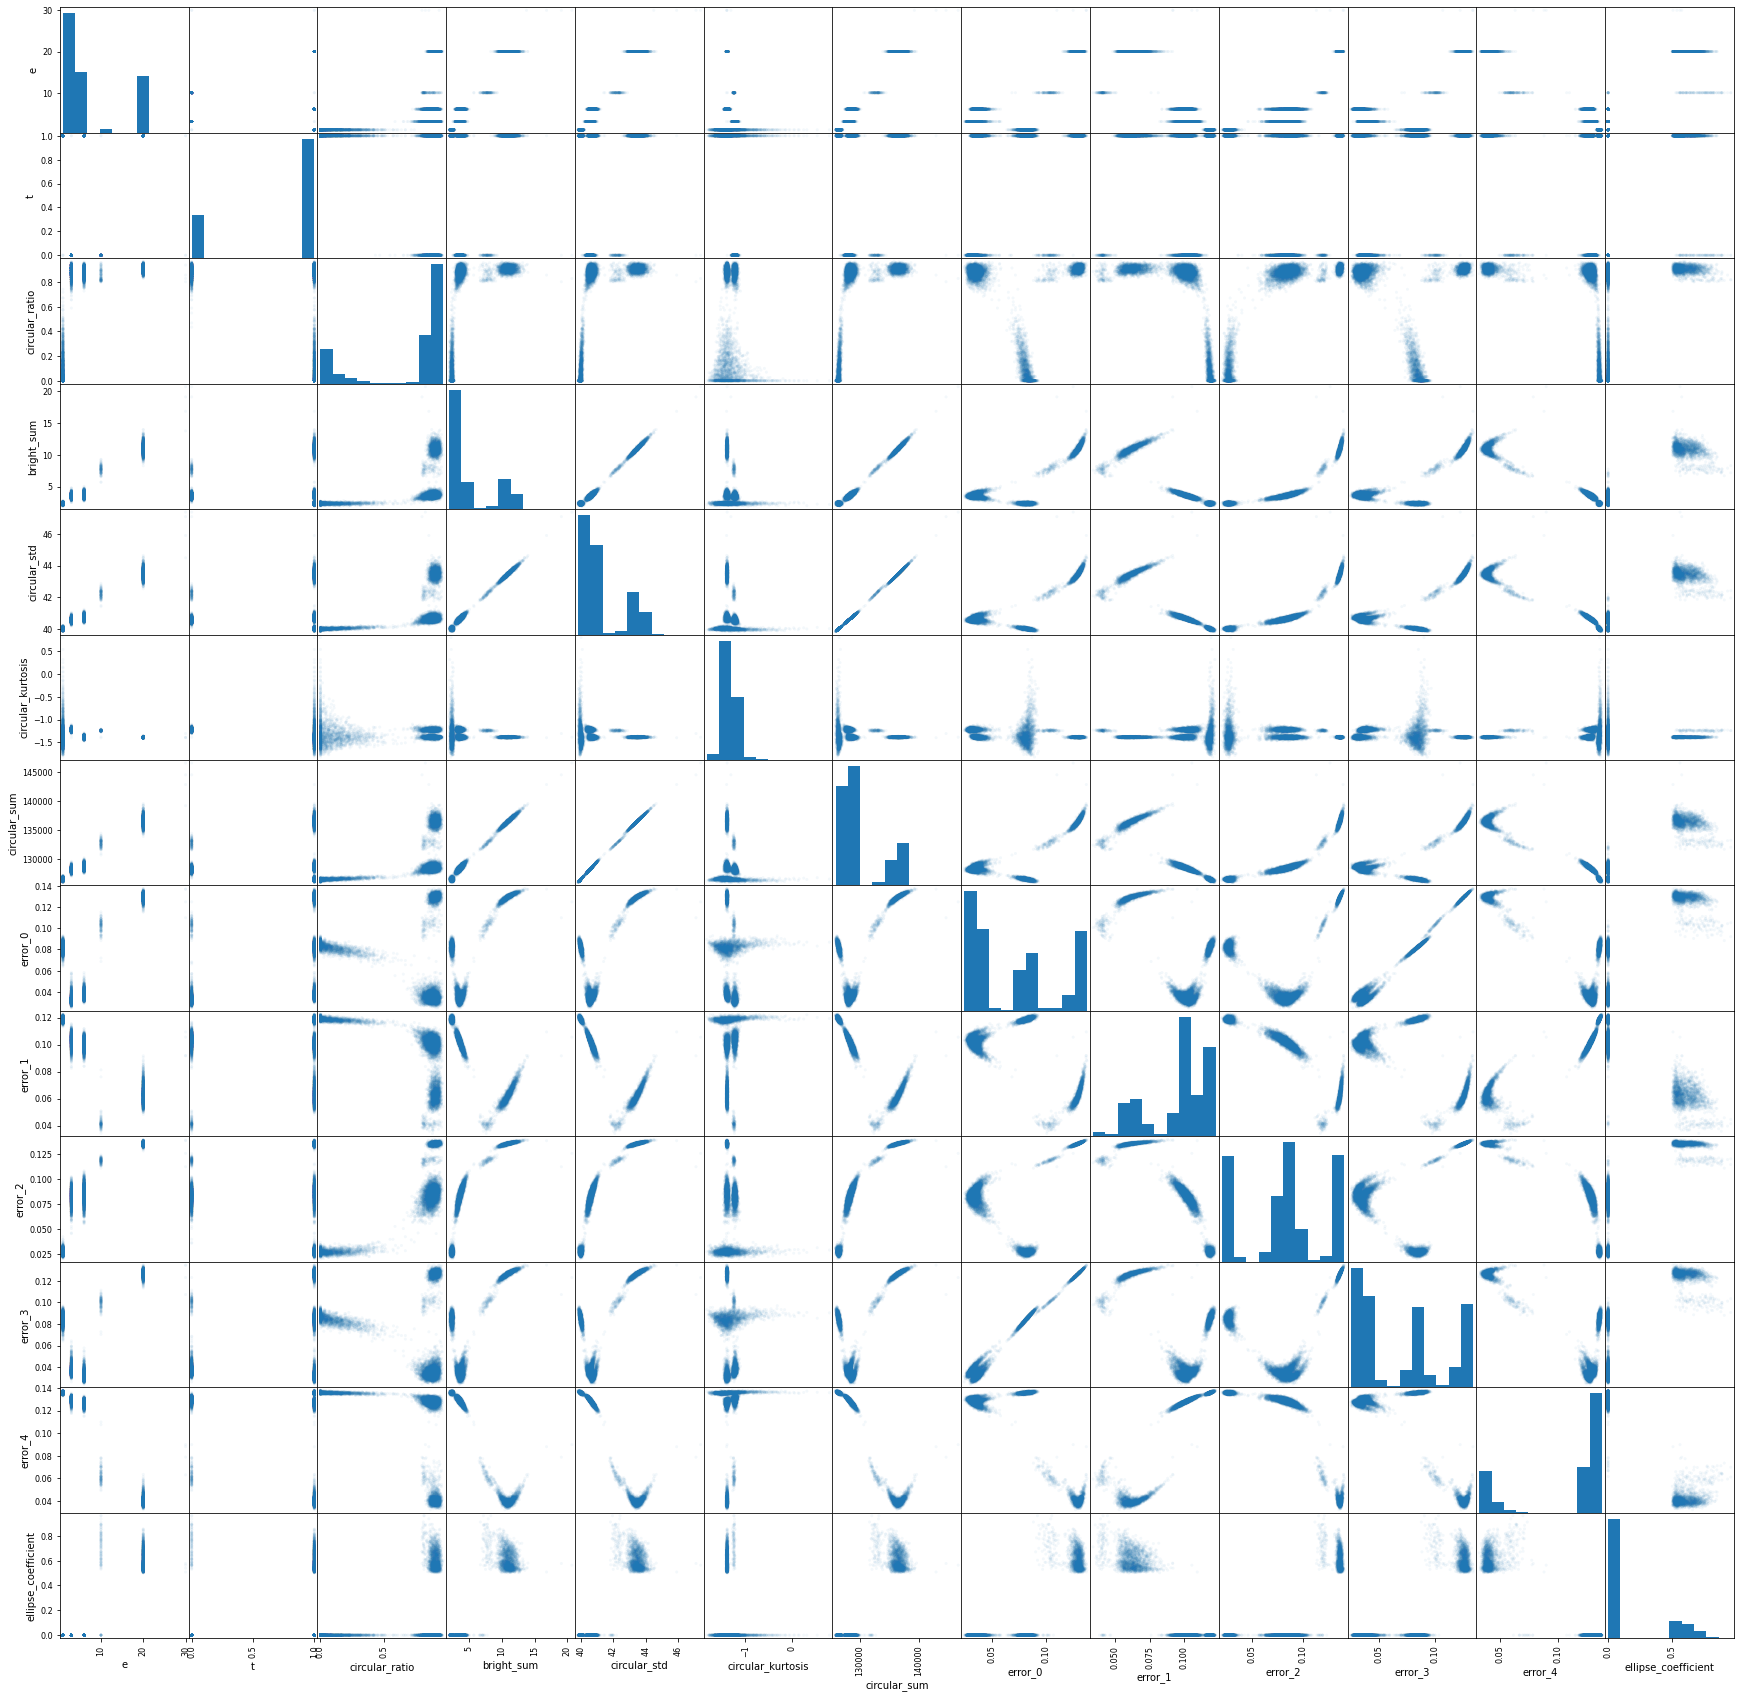

In [7]:
scatter_matrix(df[['e', 't', 'circular_ratio', 'bright_sum', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']], alpha=0.05, figsize=(30, 30));

In [8]:
df.head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.082468,0.118320,0.028867,0.084458,0.134906
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.078849,0.119419,0.029845,0.080030,0.136097
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.132114,0.068321,0.136251,0.129762,0.039316
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034932,0.102813,0.082102,0.030629,0.128451
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.129646,0.060917,0.135954,0.127263,0.037500


# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Обучение модели на классификацию ER3 и NR6, подходит так-же для (ER1/NR3) и (ER6/NR10)

In [42]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x), np.mean(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

4487 0.5001114330287497


#### CatBoostRegressor:

In [43]:
particle_types_model_ER3_NR6 = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model_ER3_NR6.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model_ER3_NR6.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER3_NR6.predict(x_test)>0.5, y_test))

1.0 0.9994413407821229


#### LinearRegression:

In [44]:
particle_types_model_ER3_NR6 = LinearRegression().fit(x_train, y_train)
particle_types_model_ER3_NR6.score(x_train, y_train)


print(roc_auc_score(particle_types_model_ER3_NR6.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER3_NR6.predict(x_test)>0.5, y_test))

0.9985141085175473 0.9983271260086903


#### GradientBoostingClassifier

In [45]:
from sklearn import ensemble
particle_types_model_ER3_NR6 = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model_ER3_NR6.fit(x_train, y_train.ravel())

print(roc_auc_score(y_train, particle_types_model_ER3_NR6.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model_ER3_NR6.predict(x_test)>0.5))

1.0 0.9988901220865705


#### Гистограмма ответов модели:

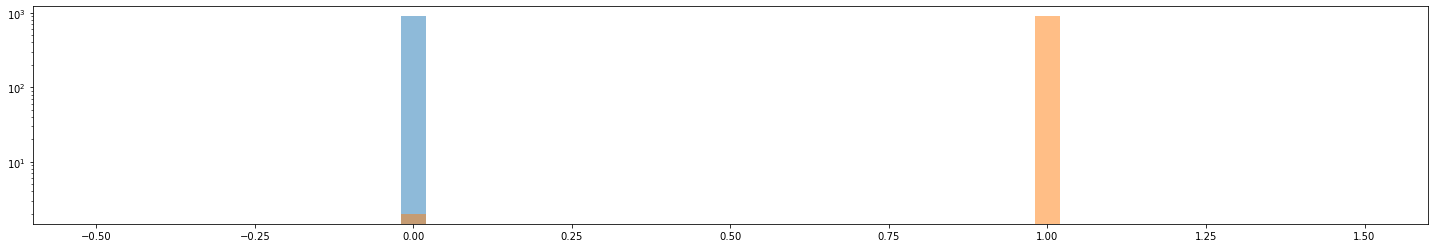

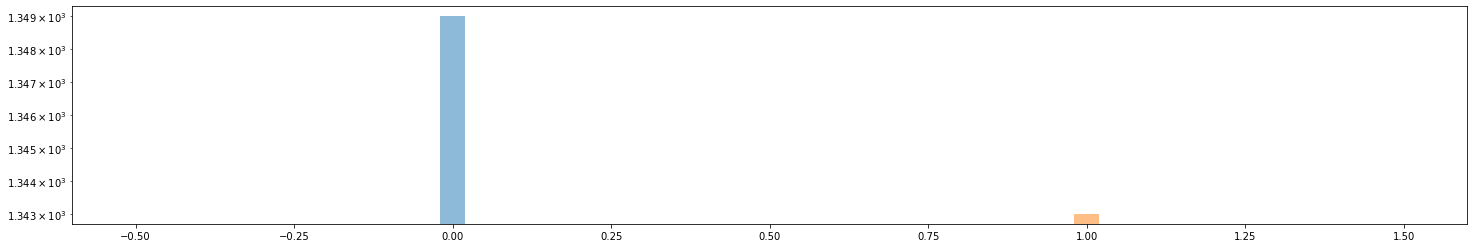

In [29]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

#### На каких частицах происходит ошибка:

In [20]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]
df_[df_.t!=(particle_types_model_ER3_NR6.predict(x)>0.5)*1].head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4
2272,1,6,0.861446,3.393998,"[[98.44, 100.340004, 99.520004, 93.340004, 97....",40.497616,127990.0000,-1.304313,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.036896,0.107588,0.070816,0.034281,0.131346
5549,1,6,0.889908,3.106998,"[[105.8, 96.3, 99.98, 103.54, 103.94, 98.64, 1...",40.444145,127823.6875,-1.284730,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.040621,0.107305,0.068991,0.039580,0.131844


#### Ошибка на классах, которые в обучении не использовались:

In [27]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==10)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)

print(sum(y==0), sum(y==1), roc_auc_score(y, particle_types_model_ER3_NR6.predict(x)>0.5))

[134] [2] 1.0


In [30]:
x = df[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df['particle_types_predict_ER3_NR6'] = particle_types_model_ER3_NR6.predict(x)

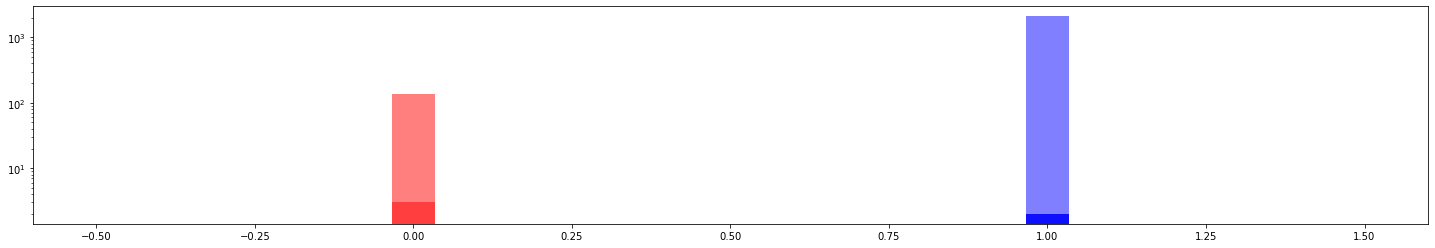

In [32]:
for e in [1, 6, 10, 20]:
    plt.hist(df[(df.e==e)&(df.t==0)].particle_types_predict_ER3_NR6, color='r', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)
    
for e in [3, 10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==1)].particle_types_predict_ER3_NR6, color='b', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Обучение модели на классификацию ER10 и NR20, подходит так-же для (ER6/NR10) и (ER20/NR30)

In [85]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x), np.mean(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

2239 0.9401518535060295


#### CatBoostRegressor:

In [86]:
particle_types_model_ER10_NR20 = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model_ER10_NR20.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model_ER10_NR20.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER10_NR20.predict(x_test)>0.5, y_test))

1.0 1.0


#### LinearRegression:

In [87]:
particle_types_model_ER10_NR20 = LinearRegression().fit(x_train, y_train)
particle_types_model_ER10_NR20.score(x_train, y_train)


print(roc_auc_score(particle_types_model_ER10_NR20.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER10_NR20.predict(x_test)>0.5, y_test))

1.0 1.0


#### GradientBoostingClassifier

In [88]:
from sklearn import ensemble
particle_types_model_ER10_NR20 = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model_ER10_NR20.fit(x_train, y_train.ravel())

print(roc_auc_score(y_train, particle_types_model_ER10_NR20.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model_ER10_NR20.predict(x_test)>0.5))

1.0 1.0


#### Гистограмма ответов модели:

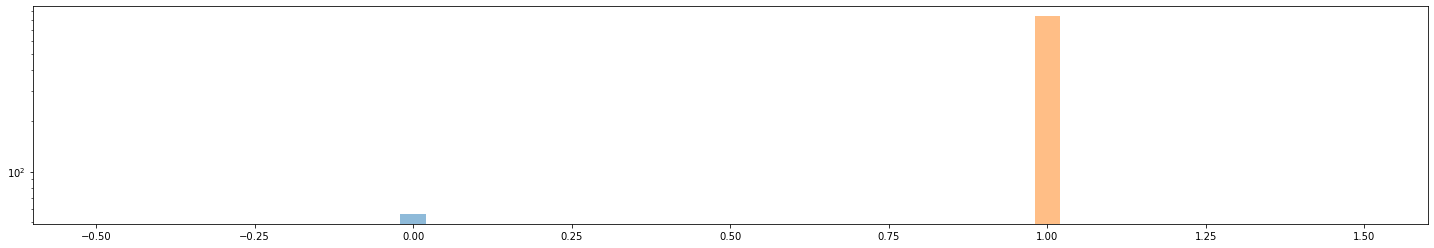

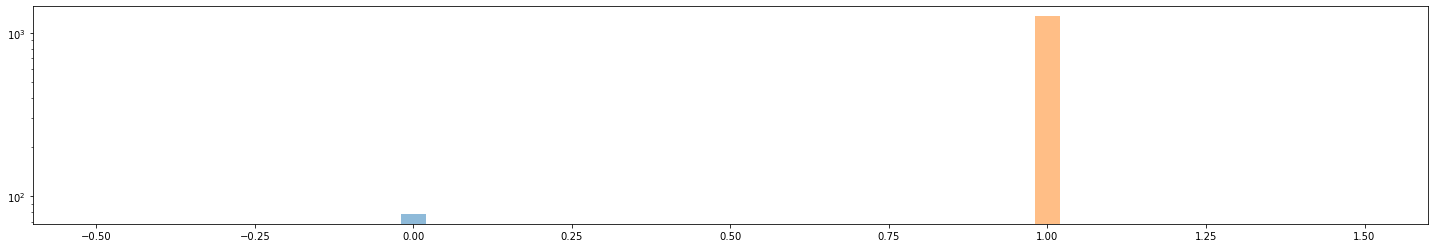

In [89]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

#### На каких частицах происходит ошибка:

In [90]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]
df_[df_.t!=(particle_types_model_ER3_NR6.predict(x)>0.5)*1].head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4,particle_types_predict_ER10_NR20


#### Ошибка на классах, которые в обучении не использовались:

In [91]:
df_ = df[(df.t==0)&(df.e==30) | (df.t==1)&(df.e==20)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)

print(sum(y==0), sum(y==1), roc_auc_score(y, particle_types_model_ER10_NR20.predict(x)>0.5))

[2] [2105] 0.75


In [92]:
x = df[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df['particle_types_predict_ER10_NR20'] = particle_types_model_ER10_NR20.predict(x)

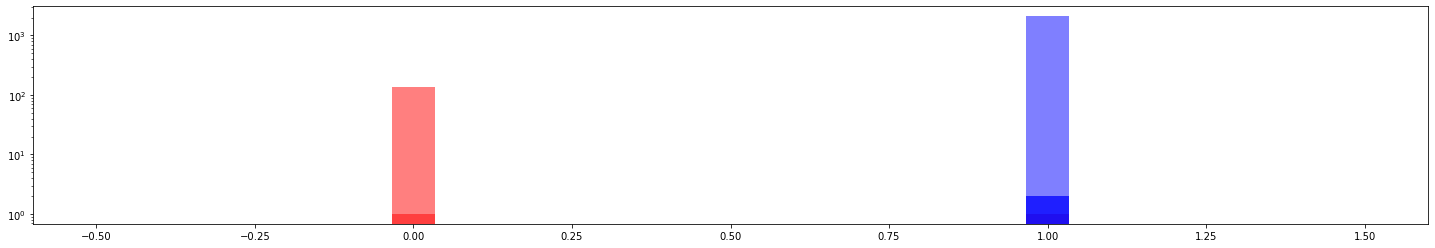

In [93]:
for e in [6, 10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==0)].particle_types_predict_ER10_NR20, color='r', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)
    
for e in [10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==1)].particle_types_predict_ER10_NR20, color='b', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Предсказание приватных данных

In [42]:
df_private = get_private_test_data((250, 250))

100%|██████████| 15058/15058 [00:07<00:00, 2142.57it/s]


In [43]:
df_private['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df_private['img_250'])))
df_private['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df_private['img_250'])))
df_private['is_center_shifted'] = ((df_private.circular_ratio<0.8)&(df_private.bright_sum>5))

100%|██████████| 15058/15058 [00:06<00:00, 2317.50it/s]


In [44]:
df_private['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df_private['img_250']))
df_private['img_80'] = df_private['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

100%|██████████| 15058/15058 [00:06<00:00, 2246.51it/s]


In [45]:
df_private['circular_std'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_std)(img) for img in tqdm(df_private['img_80']))
df_private['circular_sum'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_sum)(img) for img in tqdm(df_private['img_80']))
df_private['circular_kurtosis'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_kurtosis)(img) for img in tqdm(df_private['img_80']))

100%|██████████| 15058/15058 [00:02<00:00, 5585.31it/s]


In [59]:
df_private['ellipse_coefficient'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_ellipse_coefficient)(img) for img in tqdm(df_private['img_80']))

100%|██████████| 15058/15058 [00:02<00:00, 5451.85it/s]


In [46]:
mask = create_circular_mask(250, 250, radius=8)

In [47]:
df_private['sum'] = df_private['img_250'].map(lambda img: np.sum(img[mask])/np.sum(mask)-100.4)

In [48]:
df_private['is_center_shifted'] = ((df_private.circular_ratio<0.8)&(df_private.bright_sum>5))

In [49]:
len(df_private)

15058

In [50]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']<7.5)

5042

In [51]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']>30)

2522

In [52]:
np.sum((30>df_private[~df_private['is_center_shifted']]['sum'])&(df_private[~df_private['is_center_shifted']]['sum']>7.5))

3925

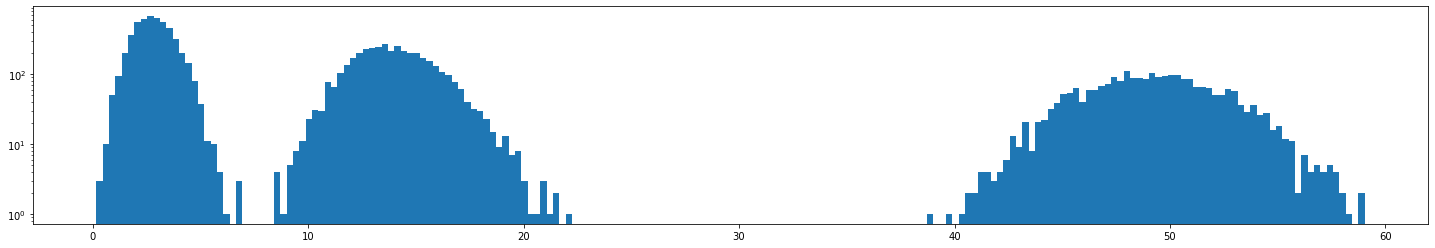

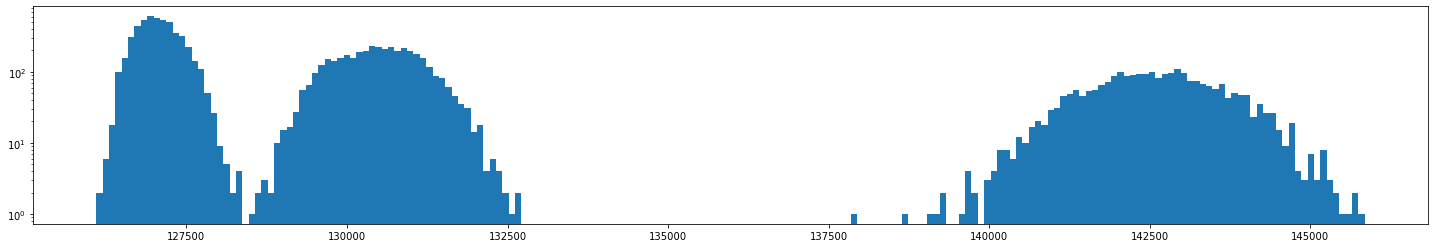

In [53]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[~df_private['is_center_shifted']]['sum'], bins=200, log=True)
plt.show()

plt.hist(df_private[~df_private['is_center_shifted']]['circular_sum'], bins=200, log=True)
plt.show()

In [56]:
df_private['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df_private['img_80']))

for i in range(len(mean_hist_matrix)):
    df_private['error_'+str(i)] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix[i], hist_matrix) for hist_matrix in df_private['hist_matrix'])

100%|██████████| 15058/15058 [00:03<00:00, 3790.08it/s]


In [57]:
df_private.head()

,file_names,id,img_250,circular_ratio,bright_sum,is_center_shifted,img_80,circular_std,circular_sum,circular_kurtosis,sum,hist_matrix,error_0,error_1,error_2,error_3,error_4
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96.png,00013a94f1fae3e5a33f8b44c2842c85f0483e96,"[[102.0, 100.0, 100.0, 100.0, 100.0, 96.0, 96....",0.878419,5.163998,False,"[[105.18, 100.1, 96.86, 101.62, 101.74, 103.66...",41.204472,130006.093750,-1.233512,14.777665,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.065398,0.071110,0.104690,0.068206,0.106158
1,0005564c011259402dcb6e3beb6e64d285124fa0.png,0005564c011259402dcb6e3beb6e64d285124fa0,"[[99.0, 99.0, 105.0, 98.0, 101.0, 97.0, 96.0, ...",0.024876,14.268999,True,"[[102.32, 99.64, 100.74, 98.380005, 100.880005...",39.812996,125358.609375,-1.016096,6.874112,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.076900,0.109661,0.063675,0.073627,0.124421
2,0007520c8d8efade8feaafbf74fc7d206cdf229d.png,0007520c8d8efade8feaafbf74fc7d206cdf229d,"[[105.0, 101.0, 102.0, 102.0, 97.0, 103.0, 107...",0.931250,17.358000,False,"[[97.26, 100.840004, 99.54, 99.18, 95.86, 100....",46.063293,143187.906250,-1.386293,51.569543,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.135935,0.116221,0.137071,0.134230,0.096402
3,000804a189f630cd980ff1543c0ef99d48cd6b34.png,000804a189f630cd980ff1543c0ef99d48cd6b34,"[[104.0, 103.0, 98.0, 101.0, 102.0, 99.0, 100....",0.437209,2.578998,False,"[[97.96, 103.28, 104.72, 98.6, 109.86, 103.26,...",40.118290,126833.804688,-1.335254,2.021320,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066761,0.115555,0.034697,0.067154,0.134359
4,000eb12def5371089743dcfe401a8e399f5883fc.png,000eb12def5371089743dcfe401a8e399f5883fc,"[[97.0, 98.0, 98.0, 104.0, 100.0, 100.0, 98.0,...",0.901538,17.177000,False,"[[99.86, 96.86, 105.1, 99.16, 101.98, 101.14, ...",45.978783,142960.562500,-1.390952,50.950254,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.135242,0.114089,0.136383,0.133324,0.092924


In [60]:
x = df_private[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df_private['particle_types_predict_ER10_NR20'] = particle_types_model_ER10_NR20.predict(x)
df_private['particle_types_predict_ER3_NR6'] = particle_types_model_ER3_NR6.predict(x)

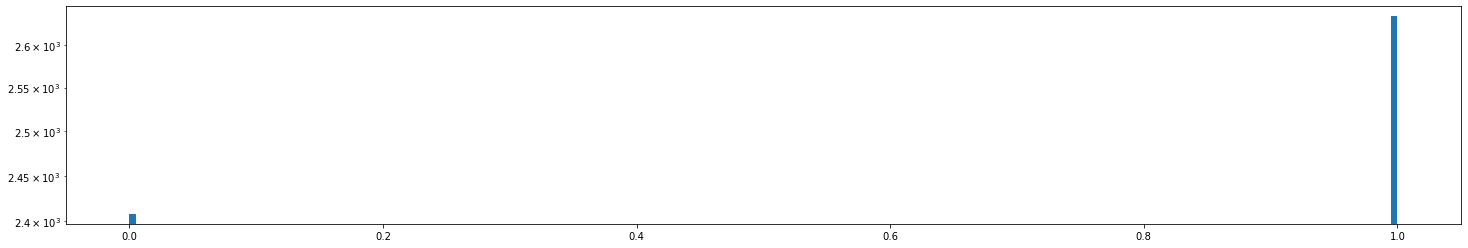

In [61]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']<7.5)]['particle_types_predict_ER3_NR6'], bins=200, log=True)
plt.show()

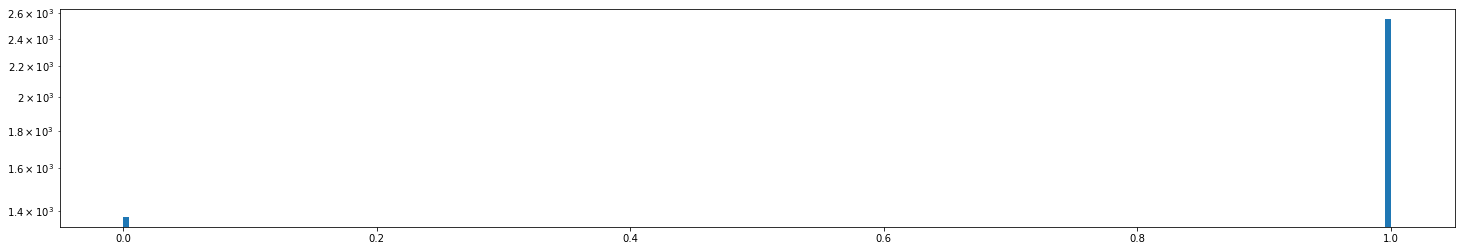

In [62]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>7.5)&(df_private['sum']<30)]['particle_types_predict_ER3_NR6'], bins=200, log=True)
plt.show()

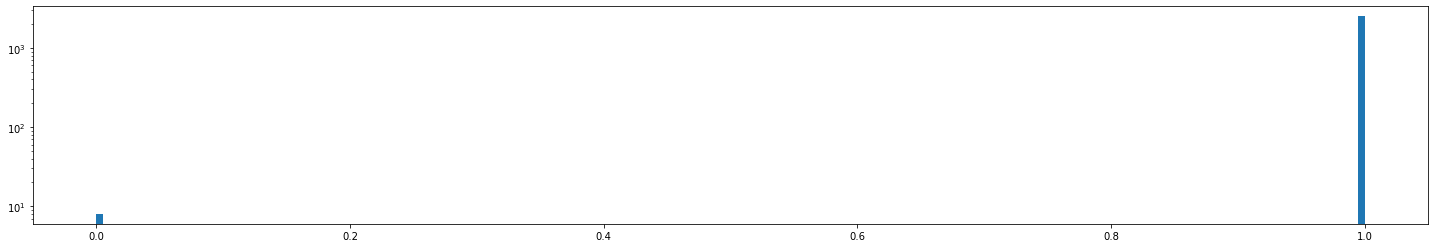

In [63]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>30)]['particle_types_predict_ER10_NR20'], bins=200, log=True)
plt.show()

In [65]:
plt.rcParams["figure.figsize"] = (10, 10)

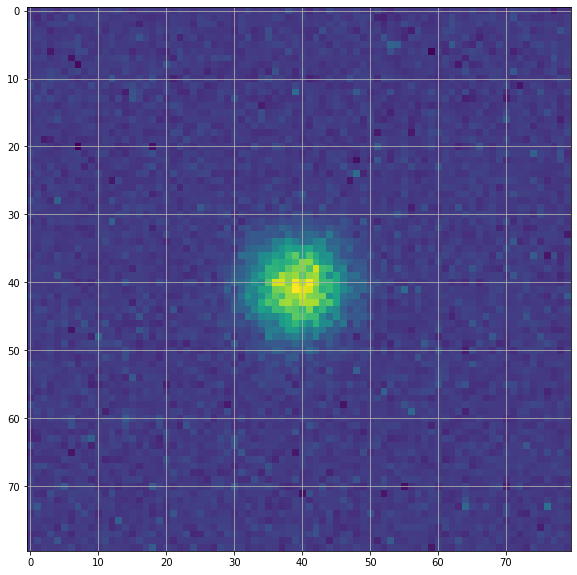

In [67]:
img = df_private[(~df_private['is_center_shifted'])&(df_private['sum']>30)&(df_private['particle_types_predict_ER10_NR20']<0.95)]['img_80'].iloc[0]
plt.imshow(img)
plt.grid()

0.5397625051077831

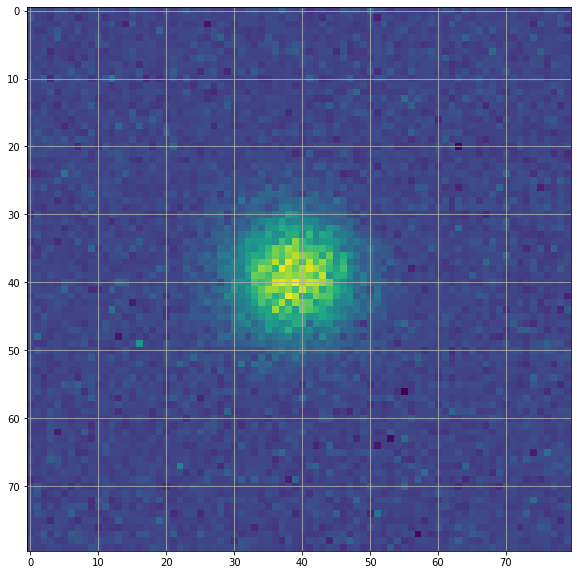

In [68]:
img = df_private[(~df_private['is_center_shifted'])&(df_private['sum']>20)&(df_private.circular_ratio<0.82)]['img_80'].iloc[2]
plt.imshow(img)
plt.grid()

get_ellipse_coefficient(img)

In [69]:
get_ellipse_coefficient

<function __main__.get_ellipse_coefficient(img)>

In [378]:
create_circular_mask(80, 80, None, 10)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

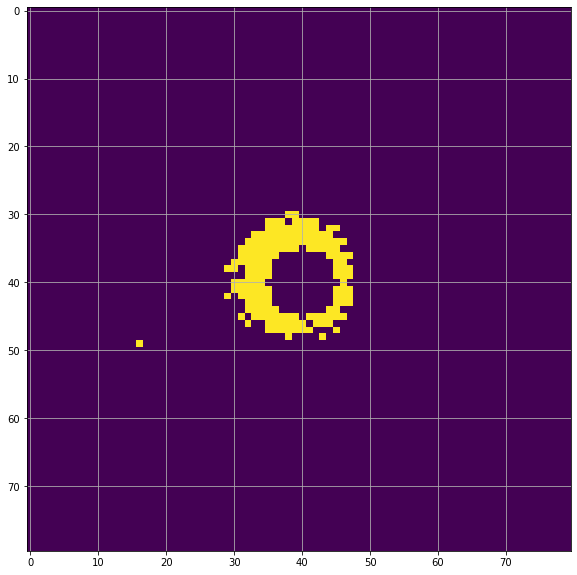

In [380]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow((img>125)&(~create_circular_mask(80, 80, None, 5)))
plt.grid()
plt.show()

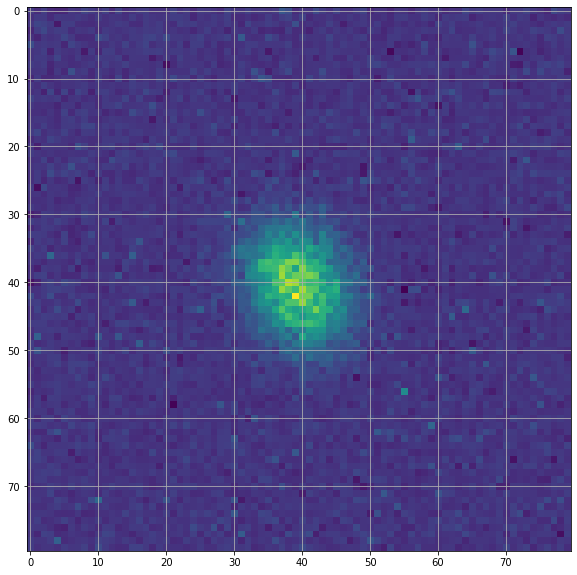

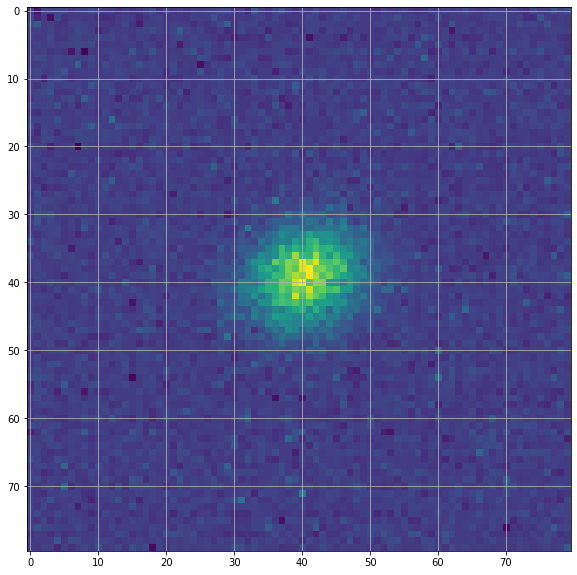

In [310]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>30)&(df_private['particle_types_predict_ER10_NR20']<0.95)]['img_80'].iloc[0])
plt.grid()
plt.show()
plt.imshow(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>30)&(df_private['particle_types_predict_ER10_NR20']<0.95)]['img_80'].iloc[3])
plt.grid()
plt.show()

In [309]:
df_private[(~df_private['is_center_shifted'])&(df_private['sum']>30)&(df_private['particle_types_predict_ER10_NR20']<0.95)]

,file_names,id,img_250,circular_ratio,bright_sum,is_center_shifted,sum,img_80,circular_std,circular_sum,circular_kurtosis,hist_matrix,error_0,error_1,error_2,error_3,error_4,particle_types_predict_ER10_NR20,particle_types_predict_ER3_NR6
1259,166db6b97fe16acd451d895fd09647d838dfec0f.png,166db6b97fe16acd451d895fd09647d838dfec0f,"[[104.0, 99.0, 98.0, 99.0, 104.0, 104.0, 105.0...",0.839286,14.879998,False,47.777665,"[[101.48, 97.04, 102.94, 96.04, 94.48, 94.92, ...",45.078423,140130.406250,-1.325898,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.127254,0.095319,0.130494,0.124496,0.077014,0.920003,0.872344
3189,36964bdf0bf421c1313ef1df686b0ea4b83a1b81.png,36964bdf0bf421c1313ef1df686b0ea4b83a1b81,"[[106.0, 102.0, 102.0, 99.0, 100.0, 102.0, 100...",0.884146,14.166000,False,51.229442,"[[99.92, 98.28, 102.5, 100.04, 95.6, 100.78, 9...",44.978397,139318.218750,-1.227598,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.110547,0.081617,0.115519,0.106673,0.074176,0.614452,0.014888
4837,52b3d43862b20b669c2a15f5296bc975fd5b946e.png,52b3d43862b20b669c2a15f5296bc975fd5b946e,"[[100.0, 98.0, 99.0, 105.0, 99.0, 101.0, 99.0,...",0.872727,13.846999,False,47.198985,"[[103.78, 98.380005, 99.560005, 94.880005, 100...",44.750896,139152.968750,-1.274960,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.123144,0.090753,0.127582,0.119760,0.076060,0.933906,0.014867
8682,92e5a3adcc604da6dcb97052118d143774c28bb4.png,92e5a3adcc604da6dcb97052118d143774c28bb4,"[[109.0, 100.0, 105.0, 102.0, 99.0, 92.0, 103....",0.855856,13.374000,False,43.975635,"[[99.82, 86.340004, 101.44, 102.54, 102.98, 10...",44.534412,138712.578125,-1.297914,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.124779,0.087079,0.128777,0.121374,0.070882,0.932713,0.015121
9908,a7b21484716f259824843d4052aa4623a335d50e.png,a7b21484716f259824843d4052aa4623a335d50e,"[[105.0, 103.0, 101.0, 98.0, 100.0, 103.0, 95....",0.850299,15.845399,False,52.838579,"[[96.0, 97.08, 99.24, 100.44, 94.54, 104.28, 1...",45.487152,140999.375000,-1.299219,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.121186,0.095011,0.123838,0.117835,0.077021,0.915028,0.015127
10222,acf8835ded44d612d18989eb3266177b492153ac.png,acf8835ded44d612d18989eb3266177b492153ac,"[[94.0, 99.0, 101.0, 100.0, 96.0, 100.0, 94.0,...",0.855856,15.046000,False,50.224365,"[[101.4, 103.86, 101.08, 106.9, 104.1, 97.86, ...",45.300915,140605.875000,-1.290947,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.122347,0.096203,0.125536,0.119103,0.079603,0.931527,0.015127
11408,c19b910d7d40c02cb01d3209ce2d3ec533826adb.png,c19b910d7d40c02cb01d3209ce2d3ec533826adb,"[[97.0, 101.0, 100.0, 100.0, 101.0, 101.0, 98....",0.861446,14.274000,False,46.341117,"[[100.68, 98.26, 100.32, 107.94, 105.74, 99.68...",44.945747,139823.437500,-1.318465,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.127009,0.094147,0.130609,0.123936,0.073895,0.935582,0.872338
14424,f451933481488c1a1b73b79983d1fb1ef3ed0738.png,f451933481488c1a1b73b79983d1fb1ef3ed0738,"[[108.0, 102.0, 95.0, 99.0, 97.0, 98.0, 99.0, ...",0.844776,14.306998,False,47.610152,"[[97.12, 98.380005, 109.24, 92.72, 100.08, 99....",44.930126,139644.765625,-1.298428,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.124124,0.091213,0.128211,0.120989,0.073404,0.917309,0.015121


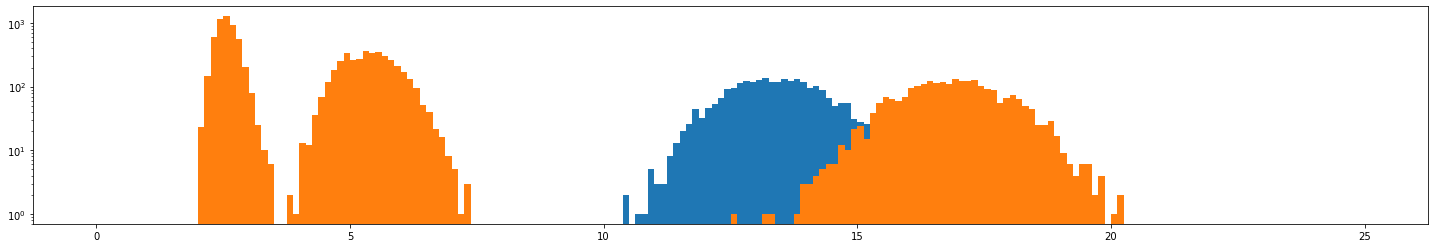

In [294]:
plt.hist(df_private[(df_private['is_center_shifted'])]['bright_sum'], bins=200, log=True, range=(0, 25))
plt.hist(df_private[(~df_private['is_center_shifted'])]['bright_sum'], bins=200, log=True, range=(0, 25))
plt.show()

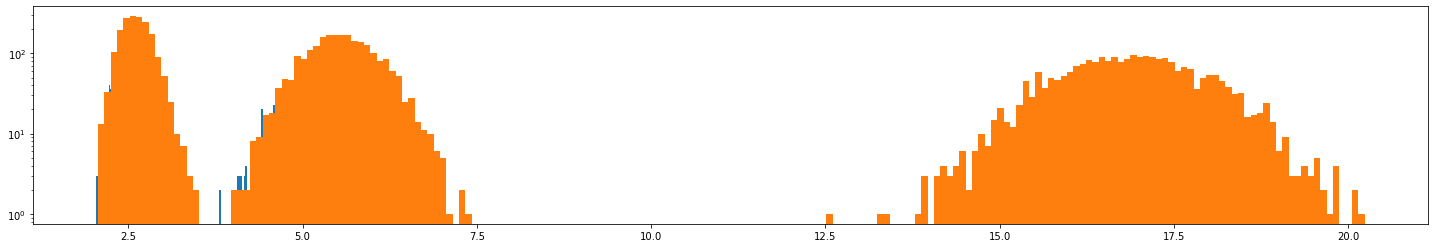

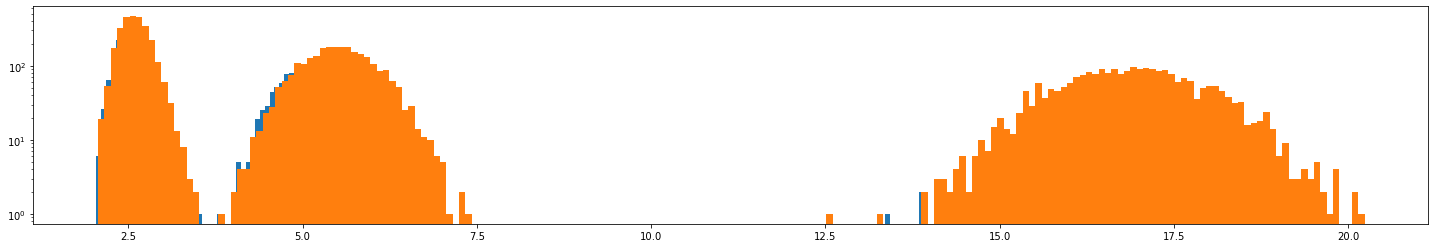

In [293]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['particle_types_predict_ER10_NR20']<0.5)]['bright_sum'], bins=200, log=True)
plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['particle_types_predict_ER10_NR20']>0.5)]['bright_sum'], bins=200, log=True)
plt.show()

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['particle_types_predict_ER3_NR6']<0.5)]['bright_sum'], bins=200, log=True)
plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['particle_types_predict_ER3_NR6']>0.5)]['bright_sum'], bins=200, log=True)
plt.show()

#### Далее классифицируем оба вида частиц по энергиям отдельно, как можно заметить классификация очень точная.


In [430]:
df_t0 = df[df.t==0]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = df_t0[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_t0['spector'].to_numpy().tolist(), x], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [431]:
energies_model_t0 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t0.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t0.predict(x_train), y_train), mean_absolute_error(energies_model_t0.predict(x_test), y_test))

0.06341908248094091 0.058577061418284705


In [432]:
energies_model_t0 = LinearRegression().fit(x_train, y_train)
energies_model_t0.score(x_train, y_train)

0.9712407765896783

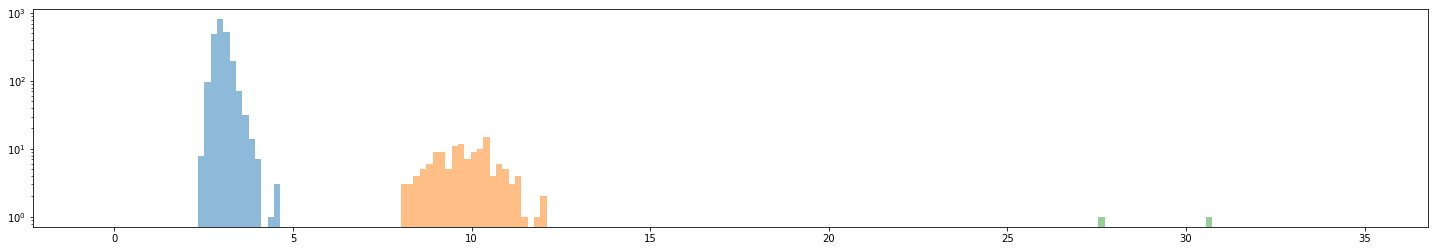

In [433]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t0.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

Классификация по энергиям частиц NR:

In [434]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([1, 6, 20])]

x = df_t0[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_t0['spector'].to_numpy().tolist(), x], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [435]:
energies_model_t1 = CatBoostRegressor(iterations=100,
                          learning_rate=3e-2,
                          l2_leaf_reg=3.0,  # any pos value
                          depth=5,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

energies_model_t1.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(mean_absolute_error(energies_model_t1.predict(x_train), y_train), mean_absolute_error(energies_model_t1.predict(x_test), y_test))

0.3589669819805687 0.3541322135248068


In [436]:
energies_model_t1 = LinearRegression().fit(x_train, y_train)
energies_model_t1.score(x_train, y_train)

0.9954656048193463

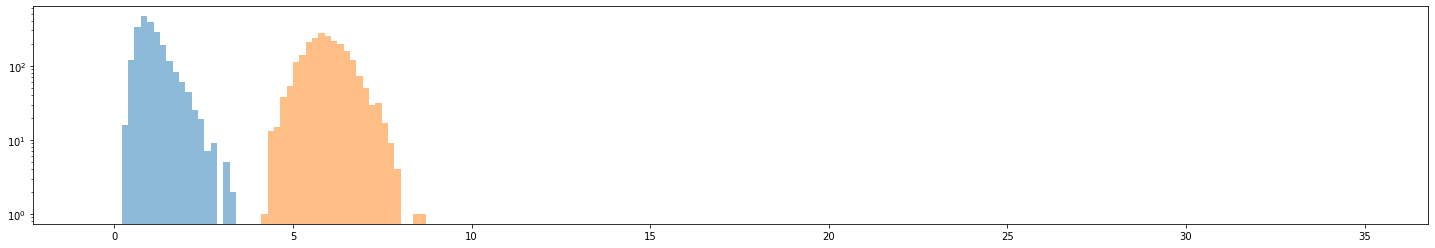

In [437]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==1]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==6]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
#plt.hist(energies_model.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35), log=True)
plt.show()

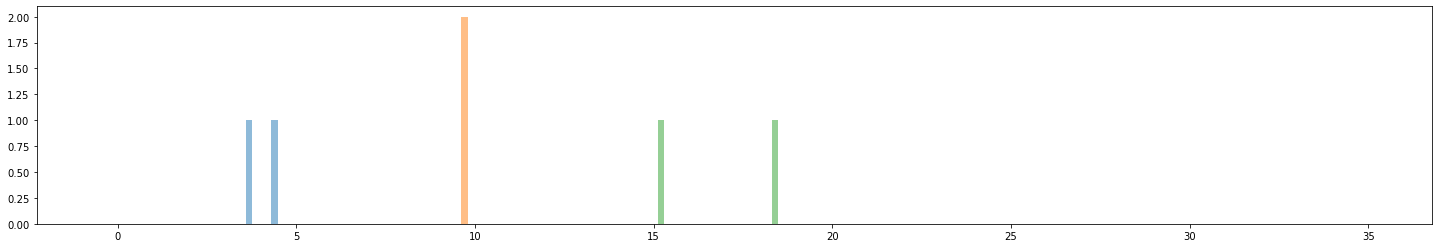

In [438]:
df_t0 = df[df.t==1]
df_t0=df_t0[df_t0.e.isin([3, 10, 30])]

x = df_t0[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_t0['spector'].to_numpy().tolist(), x], axis=1)
y = df_t0.e.to_numpy().reshape(-1, 1)

plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==3]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==10]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.hist(energies_model_t1.predict(x[y.reshape(-1)==30]), bins=200, alpha=0.5, range=(-0.5, 35))
plt.show()

## Используем полученные модели для классификации тестовых данных

In [349]:
df_test = get_test_data(input_shape=(250, 250))
df_test['circular_ratio'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_ratio)(img) for img in tqdm(df_test['img_250'])))
df_test['bright_sum'] = np.array(Parallel(n_jobs=c.NUM_CORES)(delayed(get_bright_sum)(img) for img in tqdm(df_test['img_250'])))


100%|██████████| 1502/1502 [00:01<00:00, 976.59it/s]

100%|██████████| 1502/1502 [00:02<00:00, 710.50it/s]

100%|██████████| 1502/1502 [00:01<00:00, 1105.23it/s]


In [350]:
df_test['id'] = df_test['file_names'].map(lambda file_name: file_name[:-4])

In [351]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998


In [ ]:
df_test['is_center_shifted'] = ((df_test.circular_ratio<0.8)&(df_test.bright_sum>5))

df_test['img_80'] = Parallel(n_jobs=c.NUM_CORES)(delayed(crop_image)(img, (80, 80), False) for img in tqdm(df_test['img_250']))
df_test['img_80'] = df_test['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)
df_test['spector'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(img) for img in tqdm(df_test['img_80']))

In [440]:
df_test['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df_test['img_80']))


100%|██████████| 1502/1502 [00:00<00:00, 2068.68it/s]


In [363]:
mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==1)]['hist_matrix'])
df_test['error_t1e1'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==6)]['hist_matrix'])
df_test['error_t1e6'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==1)&(df.e==20)]['hist_matrix'])
df_test['error_t1e20'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==3)]['hist_matrix'])
df_test['error_t0e3'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

mean_hist_matrix = np.mean(df[(df.t==0)&(df.e==10)]['hist_matrix'])
df_test['error_t0e10'] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix, hist_matrix) for hist_matrix in df_test['hist_matrix'])

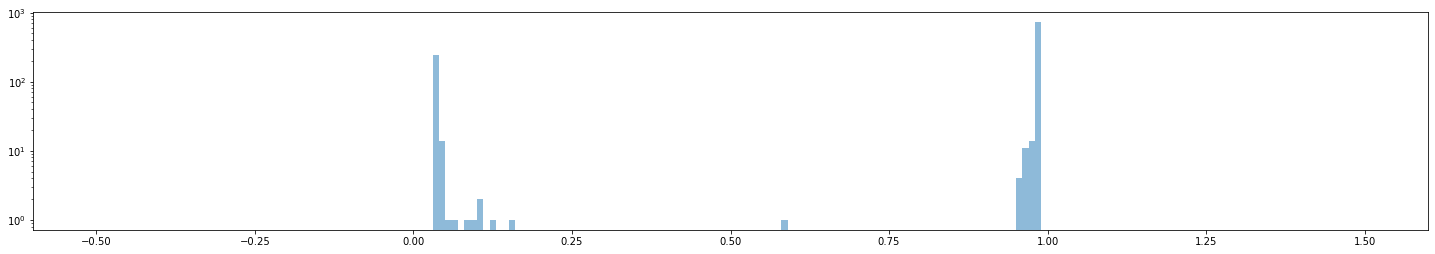

In [364]:
df_test_with_shifted_center = df_test[~df_test['is_center_shifted']]

x = df_test_with_shifted_center[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_test_with_shifted_center['spector'].to_numpy().tolist(), x], axis=1)


plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model.predict(x), bins=200, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

In [441]:
x = df_test[['bright_sum', 'circular_ratio', 'error_t1e1', 'error_t1e6', 'error_t1e20', 'error_t0e3', 'error_t0e10']].to_numpy()
x = np.concatenate([df_test['spector'].to_numpy().tolist(), x], axis=1)
df_test['particle_types_model'] = particle_types_model.predict(x)

In [442]:
df_test['t'] = ((df_test.is_center_shifted)|(df_test.particle_types_model<0.5))*1

In [443]:
df_test.head()

,file_names,id,img_250,circular_ratio,bright_sum,is_center_shifted,img_80,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,particle_types_model,t,energies_predict_t0,energies_predict_t1
0,001ec8f4d2679f2899a63e4b2597c0a10bd9393f.png,001ec8f4d2679f2899a63e4b2597c0a10bd9393f,"[[102.0, 103.0, 102.0, 103.0, 101.0, 102.0, 99...",0.895706,10.507998,False,"[[103.4, 99.74, 103.020004, 88.48, 96.8, 98.64...","[43.35074234008789, -1.3905653914049676, 13617...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014572,0.013020,0.003970,0.013763,0.007161,0.987672,0,9.481989,19.482862
1,00327390bfd6101b87106e96e0efc1c938690e1f.png,00327390bfd6101b87106e96e0efc1c938690e1f,"[[95.0, 100.0, 99.0, 104.0, 103.0, 101.0, 103....",0.796512,3.450998,False,"[[96.48, 102.98, 99.18, 100.840004, 101.74, 10...","[40.683685302734375, -1.4194284510275978, 1285...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007801,0.003376,0.013337,0.004176,0.009474,0.985874,0,3.032234,6.147138
2,00573dde8addbac780cfa35a55a790fa1aa45178.png,00573dde8addbac780cfa35a55a790fa1aa45178,"[[102.0, 94.0, 100.0, 102.0, 93.0, 102.0, 99.0...",0.889908,11.896999,False,"[[104.32, 98.26, 103.22, 100.42, 96.1, 107.58,...","[43.72025680541992, -1.3898656675759586, 13713...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014730,0.013545,0.004013,0.014192,0.007743,0.987672,0,9.481989,19.484106
3,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e.png,00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,"[[100.0, 100.0, 104.0, 101.0, 102.0, 99.0, 103...",0.823009,3.516998,False,"[[97.380005, 100.4, 98.22, 111.18, 96.5, 100.7...","[40.63819122314453, -1.4000766278244174, 12842...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007970,0.003646,0.013460,0.004256,0.009606,0.986457,0,3.032234,6.147138
4,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2.png,00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,"[[101.0, 101.0, 99.0, 103.0, 100.0, 105.0, 98....",0.861446,2.985998,False,"[[99.12, 102.8, 99.42, 107.18, 98.9, 103.56000...","[40.539207458496094, -1.4131502296642886, 1281...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007500,0.003800,0.013877,0.004359,0.009865,0.984911,0,3.027816,6.147739


In [444]:
df_test['energies_predict_t0'] = energies_model_t0.predict(x)
df_test['energies_predict_t1'] = energies_model_t1.predict(x)

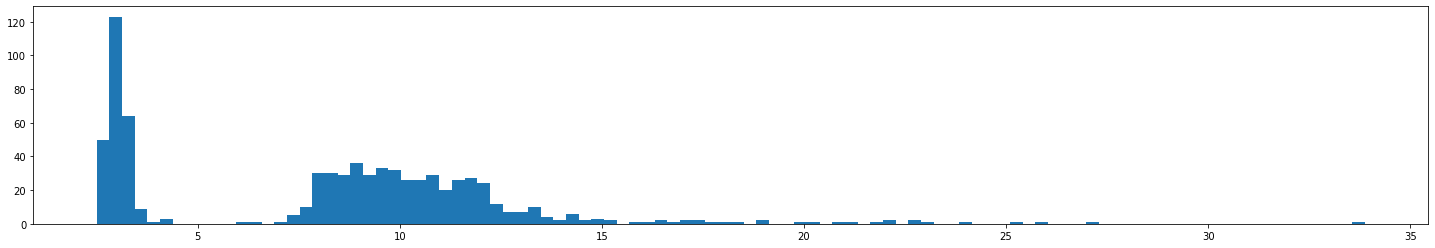

In [445]:
plt.hist(df_test[df_test.t==1]['energies_predict_t0'], bins=100)
plt.show()

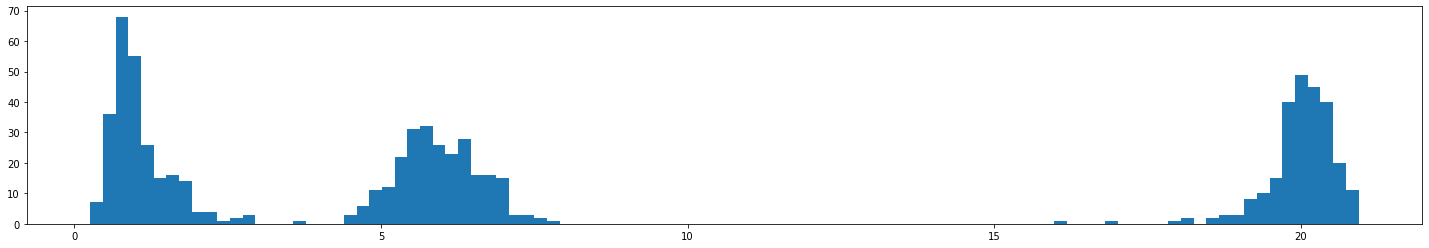

In [446]:
plt.hist(df_test[df_test.t==0]['energies_predict_t1'], bins=100)
plt.show()

In [447]:
df_test['e'] = 0
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (0<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<6)) * 3
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15)) * 10
df_test['e'] += ((~df_test.is_center_shifted) & (df_test.t==1) & (15<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<30)) * 30

df_test['e'] += ((df_test.t==0) & (0<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<4)) * 1
df_test['e'] += ((df_test.t==0) & (4<df_test['energies_predict_t1']) & (df_test['energies_predict_t1']<8)) * 6
df_test['e'] += ((df_test.t==0) & (8<df_test['energies_predict_t1'])) * 20

df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] < 12)) * 10
df_test['e'] += (df_test.is_center_shifted & (df_test['bright_sum'] > 12)) * 30

In [448]:
np.sum((df_test.t==0) & (6<df_test['energies_predict_t0']) & (df_test['energies_predict_t0']<15))

250

In [449]:
df_test[df_test.t==0]['energies_predict_t0']

0       11.039456
1        3.546762
2       12.644608
3        3.396902
4        3.181197
          ...    
1489    10.882610
1490     3.429808
1496     5.045518
1499    10.684397
1501     4.399476
Name: energies_predict_t0, Length: 753, dtype: float64

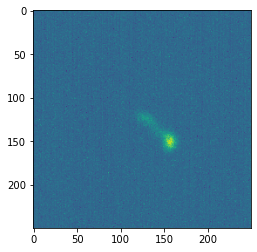

In [450]:
plt.imshow(df_test[(df_test.t==1)].iloc[1].img_250)

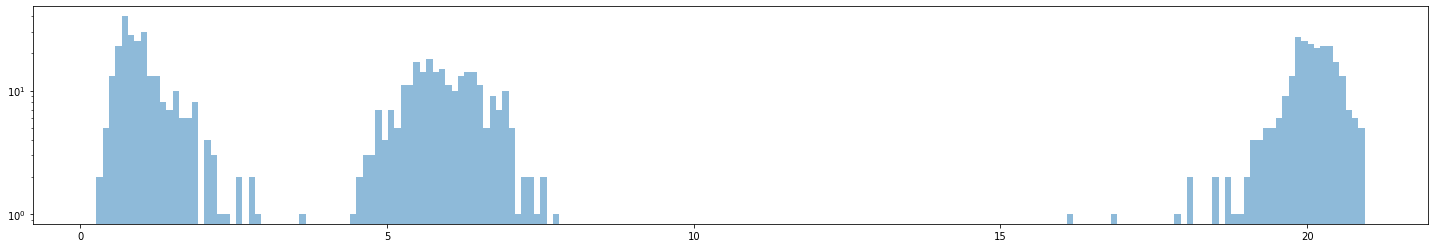

In [451]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(df_test[(df_test.t==0)]['energies_predict_t1'], bins=200, alpha=0.5, log=True)
plt.show()

In [460]:
def get_private_test_data():
    file_names = []
    data_dir = os.path.join(c.DATASET_DIR, 'private_test')
    for root, dirs, files in os.walk(data_dir):
        file_names += files
    df = pd.DataFrame(file_names, columns=['file_names'])
    df['id'] = df['file_names'].map(lambda file_name: file_name[:-4])
    df['classification_predictions'] = 1
    df['regression_predictions'] = 1
    return df


In [461]:
submission = get_private_test_data()
submission

,file_names,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96.png,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0.png,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d.png,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34.png,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc.png,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...,...
15053,ffe6d929d9537cf9b718711a63e41a1b57b509c2.png,ffe6d929d9537cf9b718711a63e41a1b57b509c2,1,1
15054,ffea775cbac98273943841d63b08377d29f08bc7.png,ffea775cbac98273943841d63b08377d29f08bc7,1,1
15055,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580.png,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,1,1
15056,ffed718417c6923844d33e70491c54396e3ec1ed.png,ffed718417c6923844d33e70491c54396e3ec1ed,1,1


In [482]:
submission = pd.concat([submission, df_test])#pd.merge(submission, df_test, how="outer", on=['id'])
submission = submission.fillna(1, axis=0)

In [483]:
submission.e = 1

In [484]:
submission = submission[['id', 't', 'e']]
submission.t = submission.t.astype(int)
submission.e = submission.e.astype(int)
submission = submission.rename(columns={"t": "classification_predictions", "e": "regression_predictions"})

In [485]:
submission.to_csv('submission.csv', index=False)

In [486]:
submission

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,1,1
3,000804a189f630cd980ff1543c0ef99d48cd6b34,1,1
4,000eb12def5371089743dcfe401a8e399f5883fc,1,1
...,...,...,...
1497,ff343a62752061d995f94ebc10ac53f79d1b5ab1,1,1
1498,ff897755cb312cd6f510ba7a38cb293e648d97d5,1,1
1499,ff9a93402457ac514cd069a7ce3f2e32692f5290,0,1
1500,ffedc12ec5c142dae2086408b778cf0db2ff944e,1,1


In [709]:
a = np.ones((250,250))*1.1

import sys
sys.getsizeof(a)/8/1000/1000*20000

1250.28

In [703]:
img_250 = df['img_250'].copy()

In [705]:
sys.getsizeof(df)/8/1000/1000

58.610112

In [706]:
df

,t,e,img_250,img_80,circular_ratio,bright_sum,spector,hist_matrix,error_t1e1,error_t1e6,error_t1e20,error_t0e3,error_t0e10,predict,particle_types_predict,img_80_circular,mean_img_error_t1e6,mean_img_error_t1e1,mean_img_error_t0e3
0,1,6,"[[105.0, 100.0, 96.0, 103.0, 99.0, 103.0, 103....","[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",0.884146,3.486998,"[40.81663513183594, -1.3736760390376546, 12899...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.089621,0.032815,0.127006,0.036447,0.101584,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.537597,4.341945,2.692320
1,1,20,"[[106.0, 97.0, 98.0, 101.0, 101.0, 101.0, 104....","[[100.380005, 100.200005, 102.36, 97.5, 97.62,...",0.925234,10.607998,"[43.46559524536133, -1.3882567428840797, 13651...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.136832,0.128730,0.040113,0.131616,0.064313,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",25.251123,39.071026,25.392618
2,1,20,"[[104.0, 101.0, 98.0, 99.0, 103.0, 105.0, 101....","[[101.14, 101.880005, 102.6, 100.94, 100.92, 1...",0.913313,9.111998,"[42.779327392578125, -1.395732821154118, 13459...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.131731,0.116460,0.050482,0.118215,0.052960,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16.600407,27.623585,16.817171
3,1,20,"[[95.0, 104.0, 101.0, 99.0, 103.0, 100.0, 98.0...","[[96.26, 100.5, 95.42, 97.18, 99.68, 101.42, 1...",0.919255,10.104999,"[43.09930419921875, -1.3965786517093128, 13546...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.134351,0.123721,0.039474,0.126379,0.053145,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",21.029377,33.446903,21.257915
4,1,20,"[[95.0, 100.0, 94.0, 98.0, 98.0, 99.0, 95.0, 1...","[[98.82, 107.0, 98.66, 102.44, 101.46, 99.54, ...",0.878419,12.223998,"[44.0062255859375, -1.374916011041052, 137931....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.136321,0.128800,0.046150,0.131614,0.072065,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",34.891815,50.991100,35.044594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13394,0,3,"[[94.0, 107.0, 97.0, 97.0, 101.0, 97.0, 101.0,...","[[101.92, 100.3, 97.72, 106.64, 99.520004, 99....",0.884146,3.268998,"[40.46708679199219, -1.2326699568996422, 12787...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.076895,0.033119,0.130850,0.031587,0.105823,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.781797,4.036243,2.644354
13396,0,3,"[[102.0, 99.0, 102.0, 101.0, 101.0, 101.0, 97....","[[105.020004, 98.8, 103.6, 110.32, 99.94, 98.6...",0.937304,3.569998,"[40.59738540649414, -1.2370356048577642, 12826...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.084810,0.035811,0.128411,0.029992,0.099661,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.846817,4.894886,2.606159
13397,0,3,"[[98.0, 100.0, 100.0, 100.0, 98.0, 102.0, 100....","[[101.380005, 99.200005, 101.86, 108.78, 100.2...",0.937304,3.802998,"[40.64213562011719, -1.2284171988470858, 12841...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.083934,0.038912,0.128708,0.032020,0.100869,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.689415,4.716643,2.457996
13398,0,3,"[[107.0, 98.0, 97.0, 101.0, 99.0, 98.0, 100.0,...","[[99.24, 100.200005, 96.18, 103.98, 97.32, 99....",0.878419,3.220398,"[40.63188934326172, -1.2772980134486802, 12839...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.079344,0.034286,0.128720,0.034540,0.103902,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2.879974,4.372777,2.857520
